In [1]:
import json, glob, re, pycm, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
EXPERIMENT_RUN_VERSION = "v9"
BENCHMARK_SIZE = 1000.

In [3]:
def display_cms(cms):
    fig = plt.figure(figsize=(20,14))
    gs = fig.add_gridspec(4, 5, hspace=0.5)
    axes = gs.subplots()
    for ax, (name, cm) in zip(axes.flat, cms):
        df = pd.DataFrame(cm.matrix).T.fillna(0)
        sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
        ax.set_title(name, wrap=True, fontsize=9)
        ax.set(xlabel='Predicted', ylabel='Actual')
    for ax in axes.flat[len(cms):]:
        ax.set_visible(False)
    plt.show()

In [4]:
def unilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "f"]]

In [5]:
def bilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n", "b"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["b"] = model_evals["b"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "b",  "f"]]

In [6]:
def plot_f1_comparison(df, figsize=(10, 6)):
    # Set the colors
    unilateral_color = '#8884d8'
    bilateral_color = '#82ca9d'

    # Create figure with larger size
    plt.figure(figsize=figsize)

    # Calculate bar positions
    x = np.arange(len(df))
    width = 0.35

    # Create bars
    bars1 = plt.bar(x - width/2, df['unilateral F1 macro'], width, label='Unilateral', color=unilateral_color, alpha=0.8)
    bars2 = plt.bar(x + width/2, df['bilateral F1 macro'], width, label='Bilateral', color=bilateral_color, alpha=0.8)

    # Set y-axis limits
    plt.ylim(0, 1.0)

    # Add value labels on top of bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    # Customize the plot
    plt.ylabel('F1 macro (given attempted)', fontsize=12)
    plt.title('Unilateral vs Bilateral Evaluation', fontsize=14, pad=20)
    plt.xticks(x, df['model'], rotation=45, ha='right')

    # Adjust layout to prevent label cutoff
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

In [7]:
cms = {}
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
    model = re.match(r'.*/unilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    cms[model]["unilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
    model = re.match(r'.*/bilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    cms[model]["bilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])

In [8]:
stats = [ 
    {
        'model': model,
        'unilateral N': cms[model]["unilateral"].POP['t'], 
        'unilateral ACC': cms[model]["unilateral"].ACC_Macro, 
        'unilateral AUC': cms[model]["unilateral"].AUC['t'], 
        'unilateral F1 macro': cms[model]["unilateral"].F1_Macro,
        'bilateral N': cms[model]["bilateral"].POP['t'], 
        'bilateral ACC': cms[model]["bilateral"].ACC_Macro, 
        'bilateral AUC': cms[model]["bilateral"].AUC['t'], 
        'bilateral F1 macro': cms[model]["bilateral"].F1_Macro,
    } 
    for model in cms 
]
stats_df = pd.DataFrame(stats)
stats_df['delta F1'] = stats_df['bilateral F1 macro'] - stats_df['unilateral F1 macro']
stats_df['unilateral coverage'] = stats_df['unilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df['bilateral coverage'] = stats_df['bilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df = stats_df[[ 'model', 
                     'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro', 
                     'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro', 
                     'delta F1' ]].sort_values('delta F1', ascending=False)

In [9]:
cms

{'claude-3-5-haiku-20241022': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'Mistral-7B-Instruct-v0.3': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'gemma-2-27b-it': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'o3-mini': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'Mixtral-8x7B-Instruct-v0.1': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'gpt-4o-2024-11-20': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])},
 'gpt-4o-mini': {'unilateral': pycm.ConfusionMatrix(classes: ['t', 'f']),
  'bilateral': pycm.ConfusionMatrix(classes: ['t', 'f'])}}

In [10]:
columns = [
    ('', 'model'),
    ('unilateral', 'coverage'),
    ('unilateral', 'ACC'),
    ('unilateral', 'AUC'),
    ('unilateral', 'F1 macro'),
    ('bilateral', 'coverage'),
    ('bilateral', 'ACC'),
    ('bilateral', 'AUC'),
    ('bilateral', 'F1 macro'),
    ('', 'delta F1')
]

original_columns = ['model',
                   'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro',
                   'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro',
                   'delta F1']

df_new = stats_df[original_columns].copy()
df_new.columns = pd.MultiIndex.from_tuples(columns)
df_new = df_new.reset_index(drop=True)

df_new = df_new.style.format({
    ('', 'model'): '{}',
    ('unilateral', 'coverage'): '{:.3f}',
    ('unilateral', 'ACC'): '{:.3f}',
    ('unilateral', 'AUC'): '{:.3f}',
    ('unilateral', 'F1 macro'): '{:.3f}',
    ('bilateral', 'coverage'): '{:.3f}',
    ('bilateral', 'ACC'): '{:.3f}',
    ('bilateral', 'AUC'): '{:.3f}',
    ('bilateral', 'F1 macro'): '{:.3f}',
    ('', 'delta F1'): '{:.3f}'
})

In [11]:
unilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
   unilateral_results += json.load(open(file, "r"))
df_unilateral = pd.DataFrame(unilateral_results)
df_unilateral_tv_dist = unilateral_truth_value_distribution(df_unilateral)

In [12]:
bilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
   bilateral_results += json.load(open(file, "r"))
df_bilateral = pd.DataFrame(bilateral_results)
df_bilateral_tv_dist = bilateral_truth_value_distribution(df_bilateral)

# Performance by model

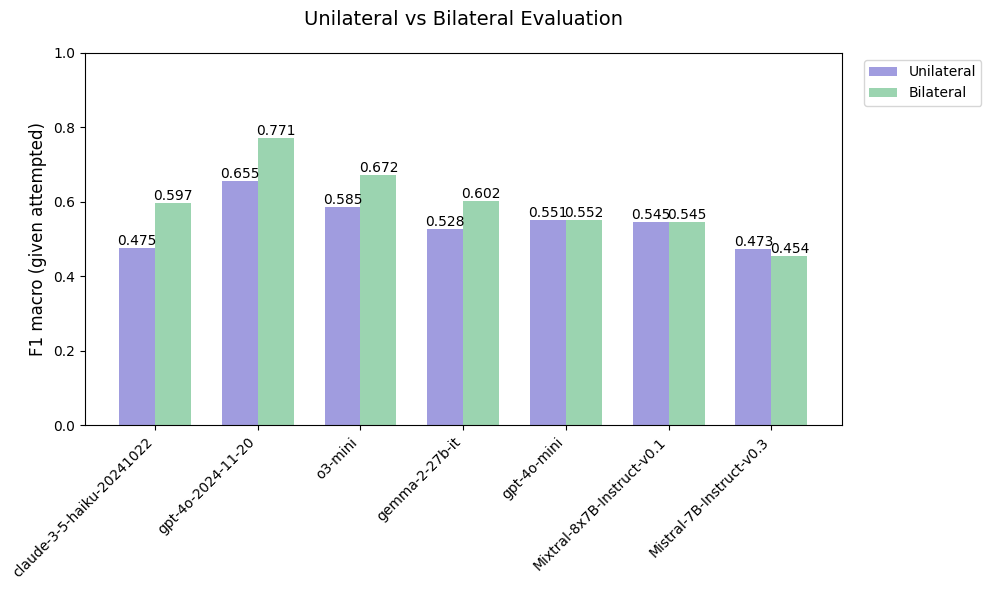

# Truth value distribution by model

## Unilateral

evaluation,t,n,f
model_name,,,
claude-3-5-haiku-20241022,0.148,0.000,0.852
google/gemma-2-27b-it,0.301,0.002,0.697
gpt-4o-2024-11-20,0.374,0.001,0.625
gpt-4o-mini,0.440,0.001,0.559
mistralai/Mistral-7B-Instruct-v0.3,0.814,0.000,0.186
mistralai/Mixtral-8x7B-Instruct-v0.1,0.524,0.008,0.468
o3-mini,0.336,0.000,0.664


## Bilateral

evaluation,t,n,b,f
model_name,,,,
claude-3-5-haiku-20241022,0.122,0.730,0.031,0.117
google/gemma-2-27b-it,0.198,0.722,0.014,0.066
gpt-4o-2024-11-20,0.191,0.427,0.094,0.288
gpt-4o-mini,0.407,0.398,0.089,0.106
mistralai/Mistral-7B-Instruct-v0.3,0.566,0.187,0.135,0.112
mistralai/Mixtral-8x7B-Instruct-v0.1,0.311,0.388,0.138,0.163
o3-mini,0.292,0.439,0.047,0.222


# Confusion matrices given attempted by model

## claude-3-5-haiku-20241022

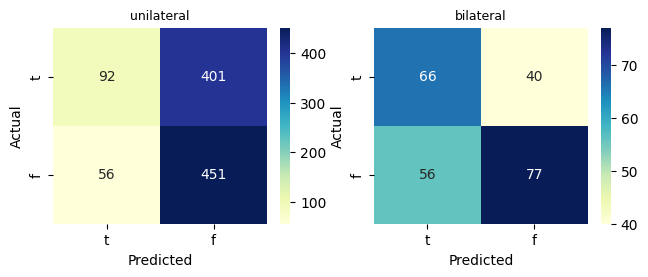

## Mistral-7B-Instruct-v0.3

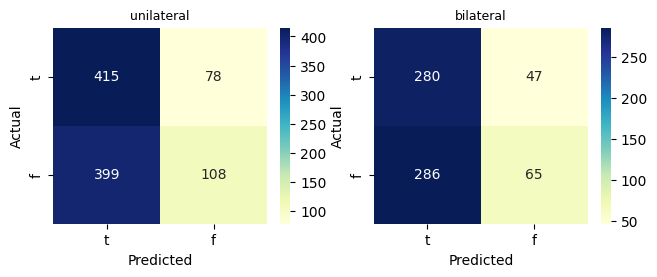

## gemma-2-27b-it

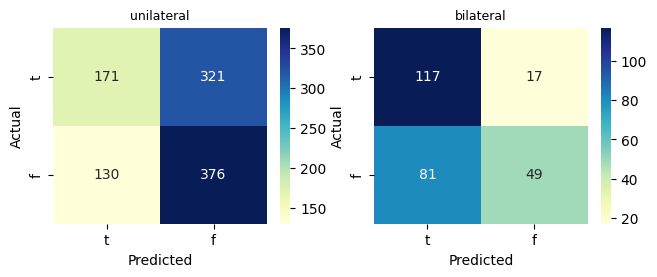

## o3-mini

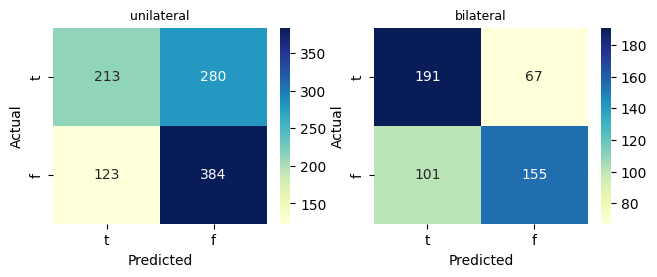

## Mixtral-8x7B-Instruct-v0.1

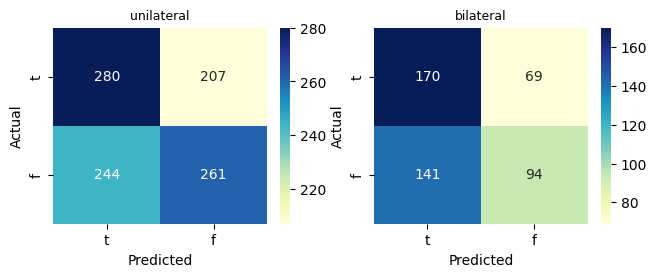

## gpt-4o-2024-11-20

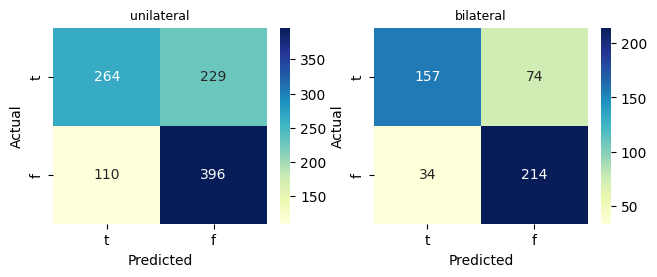

## gpt-4o-mini

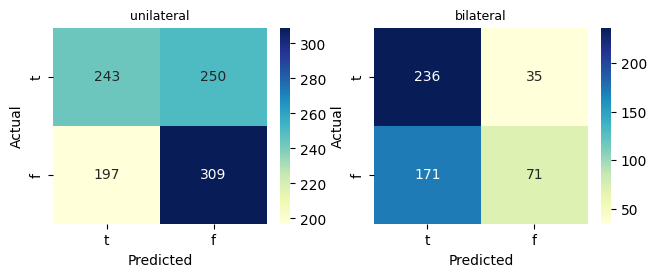

In [13]:
display(Markdown("# Performance by model"))
display(df_new)
plot_f1_comparison(stats_df)
display(Markdown("# Truth value distribution by model"))
display(Markdown(f'## Unilateral'))
display(df_unilateral_tv_dist)
display(Markdown(f'## Bilateral'))
display(df_bilateral_tv_dist)
display(Markdown("# Confusion matrices given attempted by model"))
for model in cms:
    display(Markdown(f'## {model}'))
    display_cms([
        (f"unilateral", 
         cms[model]["unilateral"]), 
        (f"bilateral", 
         cms[model]["bilateral"])])